# Non linear analysis - Assignment 3

18.10.2023 - Jérémie Engler and Laure Toullier

In [5]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import math
import pandas as pd

np.set_printoptions(precision=5, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

General data

In [6]:
E = 200e3 #Mpa
poisson = 0
sigma_y = 400 #Mpa

eps_0 = np.zeros((2,))
sigma_0 = np.zeros((2,))

strain_incr = np.array([0.003,0.004])

d = E/(1 - poisson**2) #Factor of the constitutive matrix

D = np.full((2,2), poisson)
np.fill_diagonal(D, 1)
D = D * d


In [17]:
def stress_incr_computation(strain_incr, plastic_strain_incr, n, D):
    if plastic_strain_incr.all() == 0:
        stress_incr = D @ strain_incr
    else:
        stress_incr = (D - (D @ n.T @ n @ D) / (n @ D @ n.T)) @ plastic_strain_incr
        correction_factor = (D @ n.T @ n @ D) / (n @ D @ n.T)
        trial_factor = D

    return stress_incr

def stress_for_initial_strain(strain_incr, D): # Stress increment from strain increment
    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr

    return stress_0

def check_failure(stress):
    fail = False
    criterion = stress[0]**2 + stress[1]**2 - stress[0] * stress[1] - sigma_y ** 2

    if criterion > 0:
        fail = True

    return fail

def failure_value(stress_tamp):
    criterion = stress_tamp[0]**2 + stress_tamp[1]**2 - stress_tamp[0] * stress_tamp[1] - sigma_y ** 2

    return criterion

def strain_decomposition(strain_incr, alpha):
    elastic_strain_incr = alpha * strain_incr
    plastic_strain_incr = (1 - alpha) * strain_incr

    return elastic_strain_incr, plastic_strain_incr

def norm_criterion_surface(stress_y):
    n1 = 2 * stress_y[0] - stress_y[1]
    n2 = 2 * stress_y[1] - stress_y[0]
    n = np.array([[n1,n2]])
    return n

def printgraph_with_yield_func(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'o')
    # plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'o')
    # plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None



## Steps 1 and 2

In [18]:
# Step 1

stress_0 = stress_for_initial_strain(strain_incr, D)

if check_failure(stress_0) == True:
    alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
    stress_y = alpha * stress_0

elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)

stress = stress_y

n = norm_criterion_surface(stress)

stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

stress = stress + stress_incr

print(f"Stress with 1 sub-increments: {stress} Mpa")
print(f"Criterion value = {failure_value(stress)}")

Stress with 1 sub-increments: [440.30628 400.76569] Mpa
Criterion value = 18023.108205810888


In [19]:
# Step 2

stress_0 = stress_for_initial_strain(strain_incr, D)

if check_failure(stress_0) == True:
    alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
    stress_y = alpha * stress_0

elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)

plastic_strain_incr_2 = plastic_strain_incr / 2

stress = stress_y

for sub_increment in range(2):
    n = norm_criterion_surface(stress)

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)

    stress = stress + stress_incr

    print(f"Stress, sub-increment {sub_increment + 1}: {stress} Mpa \n")

print(f"Stress with 2 sub-increments: {stress} Mpa")
print(f"Criterion value = {failure_value(stress)}")

Stress, sub-increment 1: [386.5632  422.26293] Mpa 

Stress, sub-increment 2: [384.75167 423.65081] Mpa 

Stress with 2 sub-increments: [384.75167 423.65081] Mpa
Criterion value = 4513.499097270338


## Step 3

In [20]:
def first_step(): # Function doing the part 1 and 2 of the assignment

    # Stress increment from strain increment

    stress_0 = stress_for_initial_strain(strain_incr, D)

    if check_failure(stress_0) == True:
        alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
        stress_y = alpha * stress_0

    elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)


    # Second forward step

    plastic_strain_incr_2 = plastic_strain_incr / 2

    stress = stress_y

    for sub_increment in range(2):
        n = norm_criterion_surface(stress)

        stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)

        stress = stress + stress_incr
        
    return stress, stress_y, stress_0, plastic_strain_incr, n

def forward_euler(sub_increments):

    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr

    print(f"Stress at first step: {stress_0} Mpa ")

    if check_failure(stress_0) == True:
        alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
        stress_y = alpha * stress_0

    else:
        raise ValueError("First step too small: yielding not reached")

    print(f"Criterion value at first step = {failure_value(stress_y)}")
    print(f"Yielding stress at first step: {stress_y} Mpa \n")

    elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)


    # Next forward steps

    plastic_strain_incr_2 = plastic_strain_incr / sub_increments

    print(f"Plastic strain increment = {plastic_strain_incr}")
    print(f"Plastic strain sub_increment = {plastic_strain_incr_2} \n")

    stress = stress_y

    for sub_increment in range(sub_increments):
        n = norm_criterion_surface(stress)
        print(f'n{sub_increment} = {n}')

        stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)
        print(f"Δσ{sub_increment + 1} = {stress_incr}")

        stress = stress + stress_incr
        
        print(f"Stress, sub-increment {sub_increment + 1}: {stress} Mpa \n")

    print(f"Stress with {sub_increments} sub-increments: {stress} Mpa")
    print(f"Criterion value = {failure_value(stress)}")

    return failure_value(stress)

def forward_euler_without_print(sub_increments, final_print = False):

    stresses_1 = []
    stresses_2 = []

    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr_0 = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr_0

    stresses_1.append(stress_0[0])
    stresses_2.append(stress_0[1])

    if check_failure(stress_0) == True:
        alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
        stress_y = alpha * stress_0

    else:
        raise ValueError("First step too small: yielding not reached")

    elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)

    # Next forward steps

    plastic_strain_incr_2 = plastic_strain_incr / sub_increments

    stress = stress_y

    for sub_increment in range(sub_increments):
        n = norm_criterion_surface(stress)

        stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)

        stress = stress + stress_incr

        stresses_1.append(stress[0])
        stresses_2.append(stress[1])

    if final_print == True:
        print(f"Stress with {sub_increments} sub-increments: {stress} Mpa")
        print(f"Criterion value = {failure_value(stress)} \n")

    if final_print == True:
        printgraph(stresses_1, stresses_2, "Stress 1", "Stress 2", "Mpa", "Mpa")

    return failure_value(stress)

Stress with 10 sub-increments: [376.85128 420.76683] Mpa
Criterion value = 495.09495371652883 



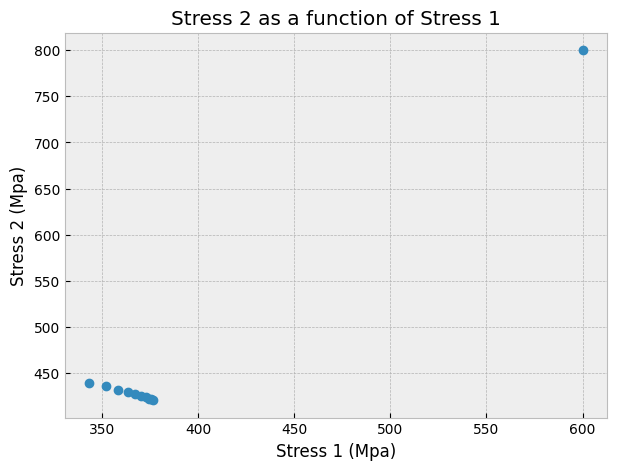

Stress with 125 sub-increments: [375.25938 420.91288] Mpa
Criterion value = 35.751173254539026 



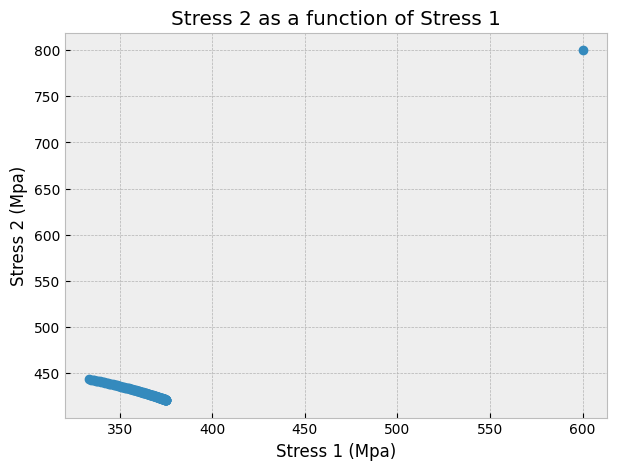

Stress with 124 sub-increments: [375.26045 420.91275] Mpa
Criterion value = 36.04198918849579 



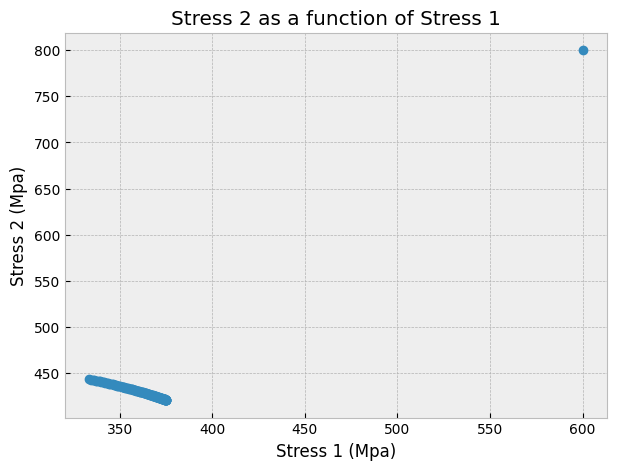

36.04198918849579

In [22]:
forward_euler_without_print(10, True)

forward_euler_without_print(125, True) #With 125, criterion smaller than error tolerance

forward_euler_without_print(124, True)

### Find the minimum number of sub-increments automatically:

In [9]:
def minimum_sub_incr_non_optimal_finder(error):
    print(f"Acceptable error = {error} \n")
    
    sub_increments = 0
    failure_value_i = error * 2

    while failure_value_i > error:  
        sub_increments = sub_increments + 1
        # print(f"Sub-increment = {sub_increments}")

        failure_value_i = forward_euler_without_print(sub_increments)
        # print(f"Failure value with {sub_increments} sub-increments: {failure_value_i} \n")

    print(f"Minimum number of sub-increments = {sub_increments}")

    return None

error = failure_value(stress_for_initial_strain(strain_incr, D)) / 1e4

minimum_sub_incr_non_optimal_finder(error)

Acceptable error = 36.0 

Minimum number of sub-increments = 125


# Bazar

In [ ]:
# # Stress increment from strain increment

# plastic_strain_incr = np.zeros((2,))
# n = np.zeros((2,))

# # First forward step

# stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

# stress_0 = sigma_0 + stress_incr

# print(f"Stress at first step: {stress_0} Mpa ")
# print(f"Criterion value = {failure_value(stress_0)}")

# if check_failure(stress_0) == True:
#     alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
#     stress_y = alpha * stress_0

# print(f"Criterion value at first step = {failure_value(stress_0)}")
# print(f"Yielding stress at first step: {stress_y} Mpa \n")

# elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)


# # Second forward step

# sub_increments = 2

# plastic_strain_incr_2 = plastic_strain_incr / sub_increments

# print(f"Plastic strain increment = {plastic_strain_incr}")
# print(f"Plastic strain sub_increment = {plastic_strain_incr_2} \n")

# stress = stress_y

# for sub_increment in range(sub_increments):
#     n = norm_criterion_surface(stress)
#     print(f'n{sub_increment} = {n}')

#     stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)
#     print(f"Δσ{sub_increment + 1} = {stress_incr}")

#     stress = stress + stress_incr
    
#     print(f"Stress, sub-increment {sub_increment + 1}: {stress} Mpa \n")

# print(f"Stress with {sub_increments} sub-increments: {stress} Mpa")
# print(f"Criterion value = {failure_value(stress)}")


In [ ]:
error = failure_value(stress_0) / 10000

print(f"Error = {error} \n")

plastic_strain_incr = np.zeros((2,))
n = np.zeros((2,))

stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

stress_0 = sigma_0 + stress_incr

sub_increments = 2

failure_value_i = forward_euler_without_print(sub_increments)

while failure_value_i > error:  
    sub_increments = sub_increments + 1
    # print(f"Sub-increment = {sub_increments}")

    failure_value_i = forward_euler_without_print(sub_increments)
    # print(f"Failure value with {sub_increments} sub-increments: {failure_value_i} \n")

print(f"Minimum number of sub-increments = {sub_increments}")

Error = 36.0 

Stress with 2 sub-increments: [384.75167 423.65081] Mpa
Criterion value = 4513.499097270338 

Stress with 3 sub-increments: [381.53907 421.10775] Mpa
Criterion value = 2234.740011534217 

Stress with 4 sub-increments: [379.7626  420.80439] Mpa
Criterion value = 1490.1969291592832 

Stress with 5 sub-increments: [378.748   420.73877] Mpa
Criterion value = 1117.1910617935355 

Stress with 6 sub-increments: [378.09597 420.72827] Mpa
Criterion value = 893.177295579866 

Stress with 7 sub-increments: [377.64239 420.73389] Mpa
Criterion value = 743.8264546760183 

Stress with 8 sub-increments: [377.30882 420.74431] Mpa
Criterion value = 637.1832648839627 

Stress with 9 sub-increments: [377.05328 420.75575] Mpa
Criterion value = 557.2399899418815 

Stress with 10 sub-increments: [376.85128 420.76683] Mpa
Criterion value = 495.09495371652883 

Stress with 11 sub-increments: [376.68761 420.7771 ] Mpa
Criterion value = 445.40507443563547 

Stress with 12 sub-increments: [376.5523